In [2]:
# %load phrase_identification.py
from collections import defaultdict
from music21 import *

from qubo_form import max_num_measures


def get_pitch_int(file):
    pitch_int = defaultdict(list)
    for i, part in enumerate(file.parts):
        notes = part.flat.getElementsByClass(['Note', 'Chord'])
        for p1,p2 in zip(notes, notes[1:]):
            intvl = interval.Interval(p1.pitches[-1],p2.pitches[-1])
            pitch_int[i].append(abs(intvl.chromatic.semitones)+1)
    return pitch_int

def get_ioi(file):
    ioi = defaultdict(list)
    for i, part in enumerate(file.parts):
        notes = part.flat.getElementsByClass(['Note', 'Chord'])
        for n1, n2 in zip(notes, notes[1:]):
            ioi[i].append(n2.offset - n1.offset)
    return ioi

def get_rests(file):
    rests = defaultdict(list)
    for i, part in enumerate(file.parts):
        notes = part.flat.getElementsByClass(['Note', 'Chord'])
        for n1, n2 in zip(notes, notes[1:]):
            rests[i].append((n2.offset) - (n1.offset + n1.duration.quarterLength)+1)
    return rests

def get_doc(no_parts, intervals):
    rdict = defaultdict(lambda: [0])
    for i in range(no_parts):
        rdict[i] += [abs(int2-int1)/(int1+int2) for int1,int2 in zip(intervals[i],intervals[i][1:])]
    return rdict

def get_strength(no_parts,intervals,doc):
    sdict = defaultdict(list)
    for i in range(no_parts):
        slist = [intervals[i][j+1]*(doc[i][j]+doc[i][j+1]) for j in range(len(intervals[i])-1)]
        s = sum(slist)
        if s!=0:
            slist = [r/s for r in slist]
        sdict[i] = slist
    return sdict

def get_measures(file, i):
    measures = []
    import math
    for n in file.parts[i].flat.getElementsByClass(['Note', 'Chord']):
        measures.append(math.ceil(n.offset / 4))
    return measures

def find_maxima(a,threshold):
    mlist = []
    for i in range(1,len(a)-1):
        if a[i]>a[i+1] and a[i-1]<a[i] and a[i]>threshold :
            mlist.append(i)
    return mlist

def find_maxima_measures(measures,mlist):
    meas_list = [0]
    if mlist!=[]:
        meas_list += [measures[m] for m in mlist]
    return meas_list


def get_phrase_list(file, p):
    no_parts = len(file.parts)

    pitch_int = get_pitch_int(file)
    rpitch = get_doc(no_parts, pitch_int)
    print(pitch_int[0])
    
    ioi = get_ioi(file)
    rioi = get_doc(no_parts, ioi)
    print(ioi[0])

    rests = get_rests(file)
    rrests = get_doc(no_parts, rests)

    spitch = get_strength(no_parts, pitch_int, rpitch)
    sioi = get_strength(no_parts, ioi, rioi)
    srests = get_strength(no_parts,rests,rrests)

    lbsp = [0] * no_parts
    max_measures = defaultdict(int)
    for i in range(no_parts):
        lbsp[i] = [0.25 * pitch + 0.5 * ioi + 0.25*rest for pitch, ioi,rest in zip(spitch[i], sioi[i],srests[i])]
        mlist = find_maxima(lbsp[i], p)
        measures = get_measures(file, i)
        max_measures[i] = find_maxima_measures(measures, mlist)
        max_measures[i].append(max_num_measures(file))

    print(len(max_measures))
    return lbsp


In [3]:
def get_phrase_list1(file, p):
    no_parts = len(file.parts)

    pitch_int = get_pitch_int(file)
    rpitch = get_doc(no_parts, pitch_int)
    print("pitches",len(pitch_int[0]))
    print()
    ioi = get_ioi(file)
    rioi = get_doc(no_parts, ioi)
    print("ioi",len(ioi[0]))
    print()

    rests = get_rests(file)
    print("rests", len(rests[0]))
    print()
    spitch = get_strength(no_parts, pitch_int, rpitch)
    sioi = get_strength(no_parts, ioi, rioi)


    lbsp = [0] * no_parts
    max_measures = defaultdict(int)
    for i in range(no_parts):
        lbsp[i] = [0.25 * pitch + 0.75 * ioi for pitch, ioi in zip(spitch[i], sioi[i])]
        mlist = find_maxima(lbsp[i], p)
        measures = get_measures(file, i)
        max_measures[i] = find_maxima_measures(measures, mlist)
        max_measures[i].append(max_num_measures(file))
    print(len(max_measures))
    return lbsp

In [4]:
p1 = 1
p2 = 1

file = converter.parse('stalker.mid')

/home/ludmila/anaconda3/envs/qumusic/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=11, channel=10, data=8>; getting generic UnpitchedPercussion
  warnings.warn(
/home/ludmila/anaconda3/envs/qumusic/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=12, channel=10, data=8>; getting generic UnpitchedPercussion
  warnings.warn(
/home/ludmila/anaconda3/envs/qumusic/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=13, channel=10, data=8>; getting generic UnpitchedPercussion
  warnings.warn(
/home/ludmila/anaconda3/envs/qumusic/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROG

In [5]:
file1 = file.measures(1,40)
lbsp1 = get_phrase_list1(file1, p1)
lbsp2 = get_phrase_list1(file1, p2)

print(len(lbsp2[0]))

pitches 22

ioi 22

rests 22

17
pitches 22

ioi 22

rests 22

17
21


In [6]:
file1.parts[1].pitches

[<music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch E2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch B2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch E2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch E2>,
 <music21.pitch.Pitch F#2>,
 <music21.pitch.Pitch G2>,
 <music21.pitch.Pitch E2>,
 <music21.pitch.Pitch B2>,
 <music21.pitch.Pitch G2>,
 <music21.pi

In [7]:
 for p in file1.parts[0].flat.getElementsByClass(['Note', 'Chord']):
        print(p.pitches[-1])

F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5
F#5


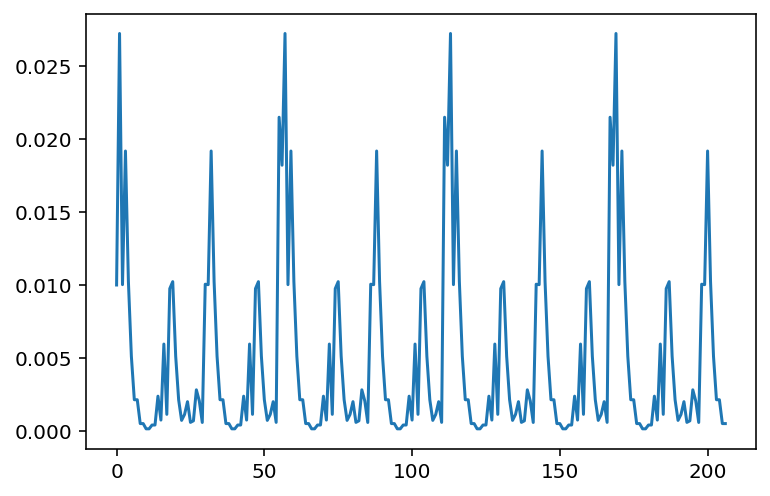

In [8]:
import matplotlib.pyplot as plt
plt.plot(lbsp1[7])

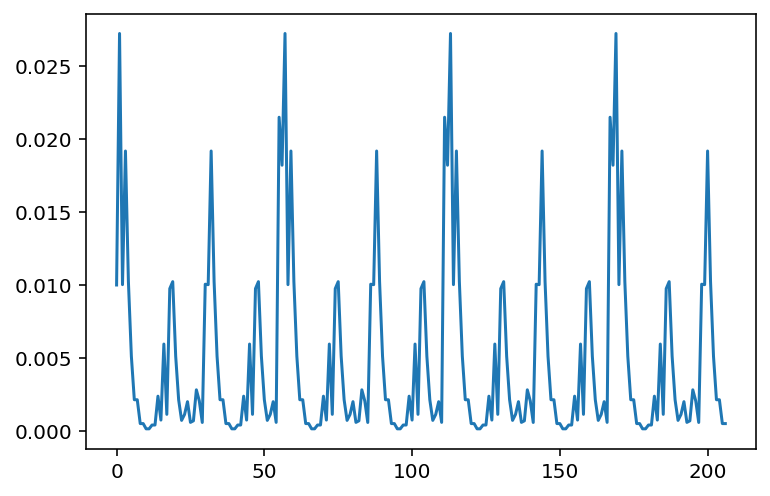

In [9]:
import matplotlib.pyplot as plt
plt.plot(lbsp2[7])

In [10]:
lbsp2[1]

[0.0,
 0.0032930237091019082,
 0.00543633845133887,
 0.0065860474182038165,
 0.005157170923379176,
 0.00543633845133887,
 0.04174066012853948,
 0.018414691714351207,
 0.007487974226953725,
 0.0032930237091019082,
 0.00543633845133887,
 0.0065860474182038165,
 0.005157170923379176,
 0.007171402766483077,
 0.007171402766483077,
 0.02040294224608243,
 0.01627720550737909,
 0.005157170923379176,
 0.0032930237091019082,
 0.00543633845133887,
 0.0065860474182038165,
 0.005157170923379176,
 0.00543633845133887,
 0.04174066012853948,
 0.018414691714351207,
 0.007487974226953725,
 0.0032930237091019082,
 0.00543633845133887,
 0.005715505979298563,
 0.0030618782031956587,
 0.0014697015375339164,
 0.004572404783438851,
 0.011431011958597127,
 0.0060452467088734805,
 0.02139216443480718,
 0.01627720550737909,
 0.005157170923379176,
 0.0032930237091019082,
 0.00543633845133887,
 0.0065860474182038165,
 0.005157170923379176,
 0.00543633845133887,
 0.04174066012853948,
 0.018414691714351207,
 0.00748

In [11]:
notes = file.parts[12].flat.getElementsByClass(['Note', 'Chord'])
for n1 in notes:
    print(n1.offset)

2.0
4.0
5.0
6.0
8.0
9.0
10.0
12.0
13.0
14.0
16.0
17.0
18.0
20.0
21.0
22.0
24.0
24.75
25.0
26.0
27.0
28.0
29.0
30.0
33.0
63.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
79.25
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
111.25
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
143.25
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
175.25
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.0
186.0
187.0
188.0
189.0
190.0
191.0
192.0
193.0
193.0
194.0
195.0
196.0
197.0
198.0
199.0
200.0
201.0
202.0
203.0
204.0
205.0
206.0
207.0
20

In [47]:
file = converter.parse('bach-air-score.mid')

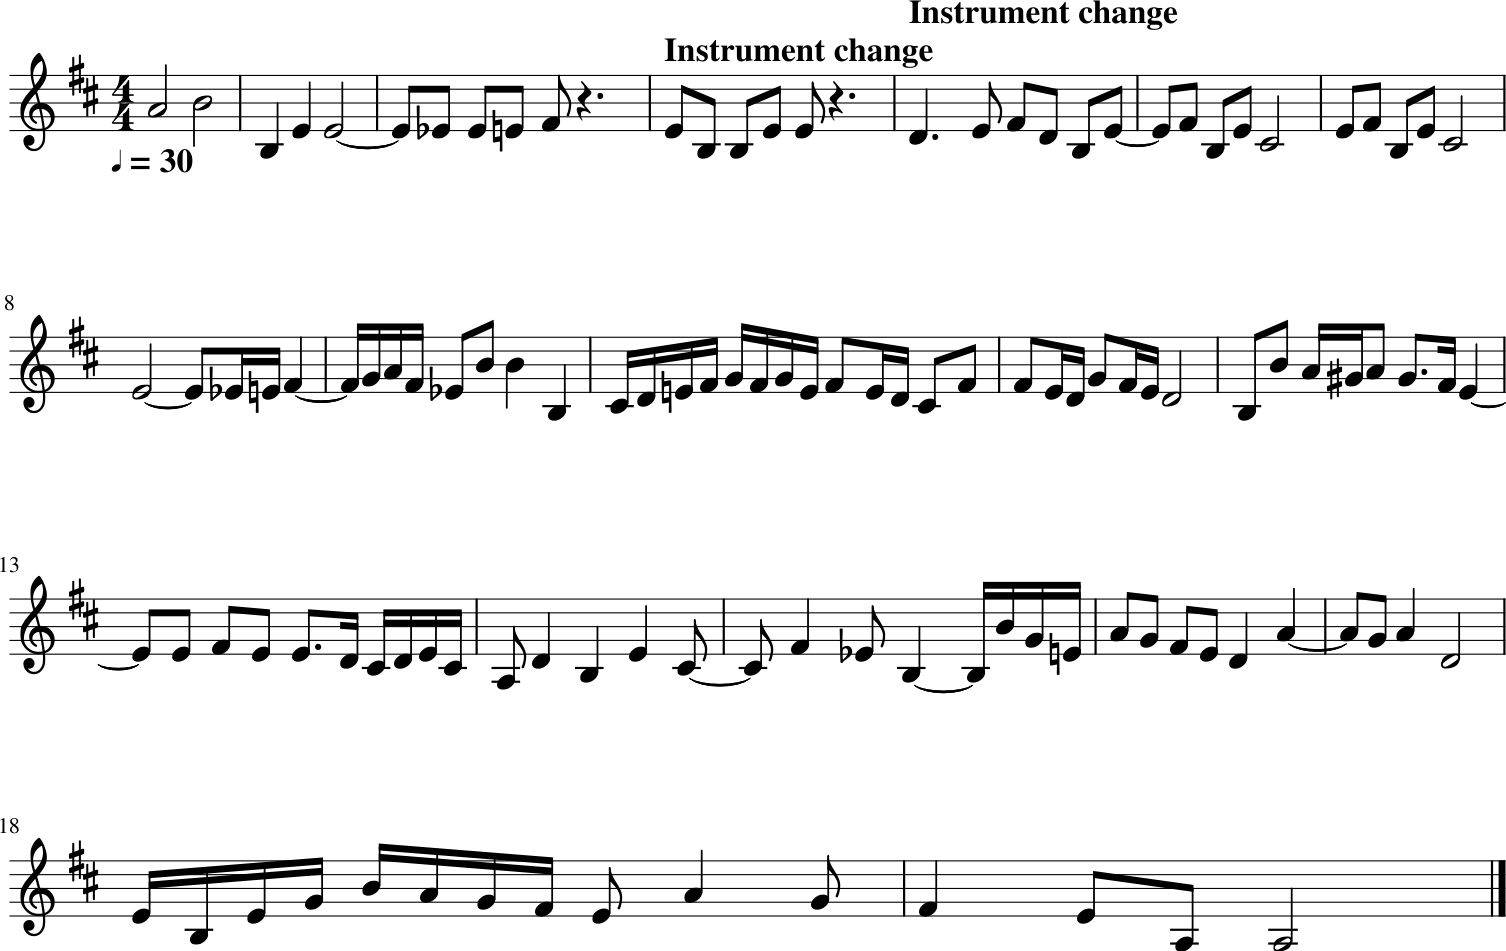

In [54]:
file.parts[2].stripTies().show()

In [55]:
for nt in file.stripTies().parts[1].measures(1,3).flat.getElementsByClass(['Note', 'Chord']):
    print(nt,nt.duration,nt.tie,nt.offset)

<music21.note.Note D> <music21.duration.Duration 5.0> None 0.0
<music21.note.Note B> <music21.duration.Duration 1.0> None 5.0
<music21.note.Note A> <music21.duration.Duration 2.5> None 6.0
<music21.note.Note C> <music21.duration.Duration 0.25> None 8.5
<music21.note.Note B> <music21.duration.Duration 0.25> None 8.75
<music21.note.Note C> <music21.duration.Duration 0.5> None 9.0
<music21.note.Note A> <music21.duration.Duration 0.25> None 9.5
<music21.note.Note C> <music21.duration.Duration 0.25> None 9.75
<music21.note.Note B> <music21.duration.Duration 0.5> None 10.0


In [56]:
for nt in file.parts[1].measures(1,3).flat.getElementsByClass(['Note', 'Chord']):
    print(nt,nt.duration,nt.tie,nt.offset)

<music21.note.Note D> <music21.duration.Duration 4.0> <music21.tie.Tie start> 0.0
<music21.note.Note D> <music21.duration.Duration 1.0> <music21.tie.Tie stop> 4.0
<music21.note.Note B> <music21.duration.Duration 1.0> None 5.0
<music21.note.Note A> <music21.duration.Duration 2.0> <music21.tie.Tie start> 6.0
<music21.note.Note A> <music21.duration.Duration 0.5> <music21.tie.Tie stop> 8.0
<music21.note.Note C> <music21.duration.Duration 0.25> None 8.5
<music21.note.Note B> <music21.duration.Duration 0.25> None 8.75
<music21.note.Note C> <music21.duration.Duration 0.5> None 9.0
<music21.note.Note A> <music21.duration.Duration 0.25> None 9.5
<music21.note.Note C> <music21.duration.Duration 0.25> None 9.75
<music21.note.Note B> <music21.duration.Duration 0.5> None 10.0


In [51]:
file.parts[12].show()

IndexError: list index out of range

In [81]:
file = converter.parse('symphony.mid')
file.parts[0].measure(1).timeSignature.numerator

2

In [87]:
file.parts[0].measure(2).offset

2.0